In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2024-05-11 20:41:59.489594: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-11 20:41:59.491315: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-11 20:41:59.522444: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-11 20:41:59.523587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 20:42:00.148981: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

# 各パス指定

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 13

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 13)                143       
                                                                 
Total params: 1213 (4.74 KB)
Trainable params: 1213 (4.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
28/42 [===================>..........] - ETA: 0s - loss: 2.4702 - accuracy: 0.1465 
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
42/42 [==============================] - 1s 6ms/step - loss: 2.4238 - accuracy: 0.1854 - val_loss: 2.2391 - val_accuracy: 0.3711
Epoch 2/1000
30/42 [====================>.........] - ETA: 0s - loss: 2.1686 - accuracy: 0.3203
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
42/42 [==============================] - 0s 4ms/step - loss: 2.1144 - accuracy: 0.3286 - val_loss: 1.8400 - val_accuracy: 0.4043
Epoch 3/1000
 1/42 [..............................] - ETA: 0s - loss: 2.0165 - accuracy: 0.3438

/home/ros-iteam/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/42 [=============>................] - ETA: 0s - loss: 1.8481 - accuracy: 0.3586
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
42/42 [==============================] - 0s 4ms/step - loss: 1.7862 - accuracy: 0.3626 - val_loss: 1.5451 - val_accuracy: 0.4251
Epoch 4/1000
39/42 [==========================>...] - ETA: 0s - loss: 1.6163 - accuracy: 0.3780
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
42/42 [==============================] - 0s 4ms/step - loss: 1.6184 - accuracy: 0.3765 - val_loss: 1.4107 - val_accuracy: 0.4431
Epoch 5/1000
27/42 [==================>...........] - ETA: 0s - loss: 1.5309 - accuracy: 0.3958
Epoch 5: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
42/42 [==============================] - 0s 4ms/step - loss: 1.5142 - accuracy: 0.3945 - val_loss: 1.3198 - val_accuracy: 0.4657
Epoch 6/1000
42/42 [==============================] - ETA: 0s - loss: 1.4514 - accuracy: 0.4045
Epoch 6: savin

In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

14/14 [==============================] - 0s 1ms/step - loss: 0.5233 - accuracy: 0.8384


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 54ms/step
[5.4429397e-02 3.3082110e-03 9.7796255e-05 8.0400001e-05 6.6006683e-02
 1.7118518e-01 4.8451883e-01 1.6426538e-01 5.6083966e-02 1.0541598e-05
 3.0110971e-09 5.7303187e-06 7.9223319e-06]
6


# 混同行列

56/56 [==============================] - 0s 930us/step


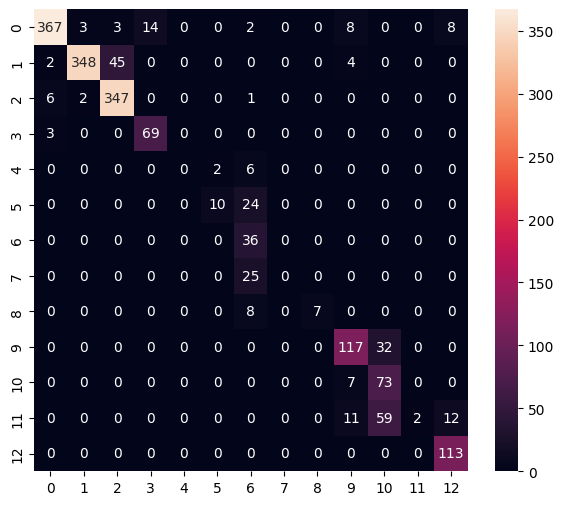

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       405
           1       0.99      0.87      0.93       399
           2       0.88      0.97      0.92       356
           3       0.83      0.96      0.89        72
           4       0.00      0.00      0.00         8
           5       0.83      0.29      0.43        34
           6       0.35      1.00      0.52        36
           7       0.00      0.00      0.00        25
           8       1.00      0.47      0.64        15
           9       0.80      0.79      0.79       149
          10       0.45      0.91      0.60        80
          11       1.00      0.02      0.05        84
          12       0.85      1.00      0.92       113

    accuracy                           0.84      1776
   macro avg       0.69      0.63      0.59      1776
weighted avg       0.87      0.84      0.82      1776



/home/ros-iteam/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ros-iteam/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ros-iteam/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

/home/ros-iteam/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpds5gbxxv/assets


INFO:tensorflow:Assets written to: /tmp/tmpds5gbxxv/assets
2024-05-11 20:42:35.396892: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-05-11 20:42:35.396915: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-05-11 20:42:35.397152: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpds5gbxxv
2024-05-11 20:42:35.397878: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-05-11 20:42:35.397887: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpds5gbxxv
2024-05-11 20:42:35.400155: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-05-11 20:42:35.400841: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-05-11 20:42:35.432062: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

6940

# 推論テスト

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 59 µs, sys: 9 µs, total: 68 µs
Wall time: 46.7 µs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.4429408e-02 3.3082131e-03 9.7796328e-05 8.0400052e-05 6.6006705e-02
 1.7118518e-01 4.8451871e-01 1.6426544e-01 5.6084007e-02 1.0541606e-05
 3.0111020e-09 5.7303173e-06 7.9223382e-06]
6
